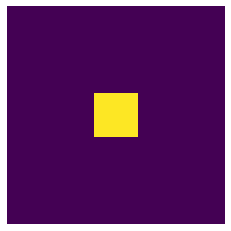

In [28]:
# snowflake simulation 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

alpha = 0.1
beta = 0.5
gamma = 0.01
u = 0
v = 0
neighbors = []
is_center = False

width = 11
height = 11
center = (width // 2 , height // 2)
num_neighbors = 4
cells = np.empty((width, height), dtype=object)

class Cell: 
    
    def __init__(self,s,coor,receptive):
        self.u = u #water used in diffusion
        self.v = v #water not used in diffusion
        self.s = s #total water 
        self.coor = coor
        self.next_u = 0 
        self.next_v = 0
        self.receptive = receptive
        
#get the neighbors for a specific coordinate
def get_neighbors(coor): 
    x, y = coor
    # in our case it is 4
    neighbors = np.array([ (x-1,y),  (x+1,y), (x,y-1), (x,y+1)  ])
    return neighbors

# boundary_cells = [center]

# initialize grid
for i in range(width):
    for j in range(height):
        coordinate = (i,j)
        if coordinate == center: 
            is_center = True
            cells[i, j] = Cell(s=1, coor=coordinate, receptive=is_center)
        else:
            is_center = False
            cells[i, j] = Cell(s=beta, coor=coordinate, receptive=is_center)
            
# actual implementation


def simulation(): 
    global cells

    # u and v for receptive and non receptive 
    for i in range(width):
        for j in range(height):
            cell = cells[i,j]
            if cell.receptive: 
                cell.next_v = cell.v + gamma
            else:
                cell.next_v = 0
                cell.next_u = cell.s # we want all water to participate in diffusion

            if i == 0 or j == 0 or i == width-1 or j == height-1: # this is for the edge cells ??? 
                cell.next_u = beta
                cell.next_v = 0
                
            # calculate u based on diffusion equation
            cell = cells[i, j]
            if not cell.receptive:
                neighbors = get_neighbors((i, j))

                ## AVERAGE NEIGHBORS CALCULATION - maybe move into a function
                # Initialize sum and count for calculating average
                sum_u_neighbors = 0
                count_neighbors = 0

                for x, y in neighbors:
                    if 0 <= x < width and 0 <= y < height:
                        # add the neighbor u value to the sum
                        sum_u_neighbors += cells[x, y].u
                        # Increment count
                        count_neighbors += 1

                # average u value of the neighbors
                if count_neighbors > 0:
                    avg_u_neighbors = sum_u_neighbors / count_neighbors
                else:
                    avg_u_neighbors = 0  # if a cell has no valid neighbors (which should not happen in this case)

                cell.next_u = cell.u + alpha * (avg_u_neighbors - cell.u) / 2

            # now need to apply the calculated next values
            cell = cells[i, j]
            cell.u = cell.next_u
            cell.v = cell.next_v
            cell.s = cell.u + cell.v
            
            # check if non-receptive cell becomes receptive
            if not cell.receptive:
                # need to set cell.receptive
                
                # frozen cells
                if cell.s >= 0:
                    cell.receptive = True
                    break

                # boundary cells
                is_neighbor_frozen = False
                # loop over each neighbor
                for x, y in get_neighbors((i, j)):
                    if 0 <= x < width and 0 <= y < height:
                        # check if the neighbor is frozen
                        if cells[x, y].s >= 0:
                            is_neighbor_frozen = True
                            cell.receptive = True
                            break  # Break the loop as soon as one receptive neighbor is found

def update_plot(frame_num, cells, img):
    simulation()
    # Update the image for the new state
    data = np.array([[cell.s for cell in row] for row in cells])
    img.set_array(data)
    return img

fig, ax = plt.subplots()
data = np.array([[cell.s for cell in row] for row in cells])
img = ax.imshow(data)
ax.axis('on')  # Turn off axis
# Create the animation
ani = FuncAnimation(fig, update_plot, frames=100, fargs=(cells, img))
plt.show()